In [ ]:
Final version

In [ ]:
"""
Pick-and-Place Three-Machine Simulated Annealing Optimization
– Each batch (BATCH_SIZE) must return to (0,0) before starting the next batch
– Ensure that each nozzle handles at most 1 component per batch
"""

import pandas as pd, random, math
from copy import deepcopy
from sklearn.utils import shuffle

# Set random seed for reproducibility
random.seed(0)
# --------------------------------------
# 1. Read Data
# --------------------------------------
df = pd.read_csv('BoardComponents-DataSet.csv')
tasks = [{'id': i, 'pos': (int(r.x), int(r.y)), 'type': r.component}
         for i, r in enumerate(df.itertuples(index=False))]

feeder_pos = {'A': (2,0), 'B': (3,0), 'C': (4,0), 'D': (5,0),
              'E': (6,0), 'F': (7,0), 'G': (8,0), 'H': (9,0),
              'I': (10,0), 'J': (11,0)}

compat = {'E1':['C','F','G'], 'E2':['C','F','G'],
          'E3':['B','G','H'], 'E4':['C','H'],
          'E5':['E','I'], 'E6':['A','E'],
          'E7':['E','J'], 'E8':['B','C','I'],
          'E9':['D']}

# --------------------------------------
# 2. Constants
# --------------------------------------
BATCH_SIZE  = 3
SWITCH_COST = 5.0
MACHINES    = ['M1','M2','M3']
HOME        = (0,0)  # Origin

# --------------------------------------
# 3. Basic Functions
# --------------------------------------
def dist(p, q): return math.hypot(p[0]-q[0], p[1]-q[1])

def get_tools_for(machine, comp, machine_tools):
    return [t for t in machine_tools[machine] if comp in compat[t]]

def build_supported(machine_tools):
    return {m: set(c for t in machine_tools[m] for c in compat[t])
            for m in MACHINES}

def equipment_load(tasks):
    d={e:0 for e in compat}
    for t in tasks:
        for e,cs in compat.items():
            if t['type'] in cs: d[e]+=1
    return d

def assign_equipment(tasks):
    sorted_e = sorted(equipment_load(tasks).items(),
                      key=lambda x: x[1], reverse=True)
    res={'M1':[], 'M2':[], 'M3':[]}
    for idx,(e,_) in enumerate(sorted_e):
        res[f'M{idx%3+1}'].append(e)
    return res

# --------------------------------------
# 4. Rebuild Batches (return None if invalid)
# --------------------------------------
def rebuild_batches(flat, machine, machine_tools):
    batches, cur, used = [], [], set()
    for task,_ in flat:
        compat_tools=get_tools_for(machine,task['type'],machine_tools)
        if not compat_tools: return None  # No usable nozzle for this machine

        choice = next((t for t in compat_tools if t not in used), None)
        if choice is None or len(cur)==BATCH_SIZE:  # Conflict / full
            if cur: batches.append(cur)
            cur,used=[],set()
            choice=compat_tools[0]

        cur.append((task,choice)); used.add(choice)
        if len(cur)==BATCH_SIZE:
            batches.append(cur); cur,used=[],set()
    if cur: batches.append(cur)
    return batches

# --------------------------------------
# 5. Initial Solution
# --------------------------------------
def initial_state(tasks, machine_tools):
    state={m:[] for m in MACHINES}
    support=build_supported(machine_tools)
    shuffled=shuffle(tasks,random_state=42)
    load={m:0 for m in MACHINES}

    for task in shuffled:
        ms=[m for m in MACHINES if task['type'] in support[m]]
        m=min(ms,key=lambda x:load[x])
        tool=random.choice(get_tools_for(m,task['type'],machine_tools))
        state[m].append((task,tool)); load[m]+=1

    for m in MACHINES:
        packed=rebuild_batches(state[m],m,machine_tools)
        if packed is None: raise RuntimeError(f'Init pack fail {m}')
        state[m]=packed
    return state

# --------------------------------------
# 6. Neighborhood
# --------------------------------------
def flat(batches): return [p for bat in batches for p in bat]

def neighbor(state,machine_tools):
    ns=deepcopy(state)
    op=random.choice(['swap_between','swap_within','move','change_tool'])

    if op=='swap_between':
        m1,m2=random.sample(MACHINES,2)
        fl1,fl2=flat(ns[m1]),flat(ns[m2])
        if not fl1 or not fl2: return None
        i,j=random.randrange(len(fl1)),random.randrange(len(fl2))
        fl1[i],fl2[j]=fl2[j],fl1[i]
        ns[m1]=rebuild_batches(fl1,m1,machine_tools)
        ns[m2]=rebuild_batches(fl2,m2,machine_tools)

    elif op=='swap_within':
        m=random.choice(MACHINES); fl=flat(ns[m])
        if len(fl)<2: return None
        i,j=random.sample(range(len(fl)),2); fl[i],fl[j]=fl[j],fl[i]
        ns[m]=rebuild_batches(fl,m,machine_tools)

    elif op=='move':
        src,dst=random.sample(MACHINES,2)
        fls, fld=flat(ns[src]),flat(ns[dst])
        if not fls: return None
        i=random.randrange(len(fls)); fld.append(fls.pop(i))
        ns[src]=rebuild_batches(fls,src,machine_tools)
        ns[dst]=rebuild_batches(fld,dst,machine_tools)

    else:  # change_tool
        m=random.choice(MACHINES); fl=flat(ns[m])
        if not fl: return None
        i=random.randrange(len(fl)); task,_=fl[i]
        tools=get_tools_for(m,task['type'],machine_tools)
        if len(tools)<2: return None
        newt=random.choice([t for t in tools if t!=fl[i][1]])
        fl[i]=(task,newt); ns[m]=rebuild_batches(fl,m,machine_tools)

    if any(b is None for b in ns.values()): return None
    return ns

# --------------------------------------
# 7. Cost: Return to HOME between batches
# --------------------------------------
def total_cost(state):
    tot=0.0
    for m in MACHINES:
        cur,tool=HOME,None
        for batch in state[m]:
            # If not first batch, cur is already at HOME (returned after previous batch)
            # 1) Pick: Return to HOME (already at HOME for the first batch)
            if cur!=HOME:
                tot+=dist(cur,HOME); cur=HOME
            for task,t in batch:
                if tool!=t: tot+=SWITCH_COST; tool=t
                feeder=feeder_pos[task['type']]
                tot+=dist(cur,feeder); cur=feeder
            # 2) Place
            for task,t in batch:
                if tool!=t: tot+=SWITCH_COST; tool=t
                tot+=dist(cur,task['pos']); cur=task['pos']
            # 3) Return to HOME to start next batch
            tot+=dist(cur,HOME); cur=HOME
    return tot

# --------------------------------------
# 8. Simulated Annealing
# --------------------------------------
def anneal(tasks,machine_tools,T0=200,alpha=0.95,iters=200,Tmin=1e-2):
    cur = initial_state(tasks, machine_tools)
    best = deepcopy(cur)
    cur_cost = best_cost = total_cost(cur)
    T = T0

    move_trace = [sum(dist(HOME, feeder_pos[task['type']]) + 
                      dist(feeder_pos[task['type']], task['pos']) + 
                      dist(task['pos'], HOME)
                      for batch in cur[m]
                      for task, _ in batch)
                  for m in MACHINES]  # Initial move distance record

    total_move_trace = [sum(move_trace)]  # Initial pure move distance

    while T > Tmin:
        for _ in range(iters):
            nb = None
            for _ in range(30):
                nb = neighbor(cur, machine_tools)
                if nb is not None:
                    break
            if nb is None:
                continue

            nb_cost = total_cost(nb)
            dE = nb_cost - cur_cost
            if dE < 0 or random.random() < math.exp(-dE / T):
                cur = nb
                cur_cost = nb_cost
                if nb_cost < best_cost:
                    best, best_cost = deepcopy(nb), nb_cost

                # Record current pure movement distance (excluding switch cost)
                move = 0.0
                for m in MACHINES:
                    for batch in cur[m]:
                        cur_pos = HOME
                        for task, _ in batch:
                            move += dist(cur_pos, feeder_pos[task['type']])
                            cur_pos = feeder_pos[task['type']]
                        for task, _ in batch:
                            move += dist(cur_pos, task['pos'])
                            cur_pos = task['pos']
                        move += dist(cur_pos, HOME)
                total_move_trace.append(move)

        T *= alpha

    return best, best_cost, total_move_trace

# --------------------------------------
# 9. Action Log (includes return to HOME at batch end)
# --------------------------------------
def record(state):
    rows=[]
    for m in MACHINES:
        cur,tool=HOME,None; batch_idx=0; op=0
        for batch in state[m]:
            # Return (end of last batch → HOME); skip for first batch
            if cur!=HOME:
                rows.append(dict(Machine=m,Batch=batch_idx-1,Step=f'Return{op}',
                                 Comp='-',Tool=tool,From=cur,To=HOME,
                                 Dist=round(dist(cur,HOME),2),Switch=0))
                cur,op=HOME,op+1
            # Pick
            for task,t in batch:
                feeder=feeder_pos[task['type']]
                rows.append(dict(Machine=m,Batch=batch_idx,Step=f'Pick{op}',
                                 Comp=task['type'],Tool=t,From=cur,To=feeder,
                                 Dist=round(dist(cur,feeder),2),
                                 Switch=int(tool!=t)))
                tool,cur,op=t,feeder,op+1
            # Place
            for task,t in batch:
                rows.append(dict(Machine=m,Batch=batch_idx,Step=f'Plc{op}',
                                 Comp=task['type'],Tool=t,From=cur,To=task['pos'],
                                 Dist=round(dist(cur,task['pos']),2),
                                 Switch=int(tool!=t)))
                tool,cur,op=t,task['pos'],op+1
            # Return to HOME
            rows.append(dict(Machine=m,Batch=batch_idx,Step=f'Return{op}',
                             Comp='-',Tool=tool,From=cur,To=HOME,
                             Dist=round(dist(cur,HOME),2),Switch=0))
            cur,op=HOME,op+1; batch_idx+=1
    return pd.DataFrame(rows)

# --------------------------------------
# 10. Run
# --------------------------------------
if __name__=='__main__':
    machine_tools=assign_equipment(tasks)
    print('Equipment assignment:',machine_tools)

    state, best, trace = anneal(tasks, machine_tools)
    print('Best total cost:',best)

    df=record(state)
    df.to_csv('optimized_board_assembly_batch3_HOME.csv',index=False)
    move=df['Dist'].sum(); switches=df['Switch'].sum()
    print(f'\nPure movement distance : {move:.2f}')
    print(f'Tool switches           : {switches}')
    print(f'⇢ With tool switch cost : {move+switches*SWITCH_COST:.2f}')

    print('\nTotal cost per machine:')
    for m in MACHINES:
        sub=df[df['Machine']==m]
        cost=sub['Dist'].sum()+sub['Switch'].sum()*SWITCH_COST
        print(f'  {m}: {cost:.2f}')

import matplotlib.pyplot as plt

plt.plot(trace)
plt.title("Total Movement Distance per Accepted Solution")
plt.xlabel("Accepted Steps")
plt.ylabel("Pure Movement Distance")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Environment reset, reload data and run greedy path planning
import pandas as pd, math
from collections import defaultdict

# Load dataset
df = pd.read_csv("BoardComponents-DataSet.csv")
tasks = [{'id': i, 'pos': (int(r.x), int(r.y)), 'type': r.component}
         for i, r in enumerate(df.itertuples(index=False))]

# Constants and configuration
feeder_pos = {'A': (2,0), 'B': (3,0), 'C': (4,0), 'D': (5,0),
              'E': (6,0), 'F': (7,0), 'G': (8,0), 'H': (9,0),
              'I': (10,0), 'J': (11,0)}
compat = {'E1':['C','F','G'], 'E2':['C','F','G'],
          'E3':['B','G','H'], 'E4':['C','H'],
          'E5':['E','I'], 'E6':['A','E'],
          'E7':['E','J'], 'E8':['B','C','I'],
          'E9':['D']}
MACHINES = ['M1','M2','M3']
HOME = (0,0)
SWITCH_COST = 5.0
BATCH_SIZE = 3

# Utility functions
def dist(p, q): return math.hypot(p[0]-q[0], p[1]-q[1])
def get_tools_for(machine, comp, machine_tools):
    return [t for t in machine_tools[machine] if comp in compat[t]]
def build_supported(machine_tools):
    return {m: set(c for t in machine_tools[m] for c in compat[t])
            for m in MACHINES}
def equipment_load(tasks):
    d = {e:0 for e in compat}
    for t in tasks:
        for e,cs in compat.items():
            if t['type'] in cs: d[e] += 1
    return d
def assign_equipment(tasks):
    sorted_e = sorted(equipment_load(tasks).items(), key=lambda x: x[1], reverse=True)
    res = {'M1': [], 'M2': [], 'M3': []}
    for idx, (e, _) in enumerate(sorted_e):
        res[f'M{idx%3+1}'].append(e)
    return res
def rebuild_batches(flat, machine, machine_tools):
    batches, cur, used = [], [], set()
    for task, _ in flat:
        compat_tools = get_tools_for(machine, task['type'], machine_tools)
        if not compat_tools:
            return None
        choice = next((t for t in compat_tools if t not in used), None)
        if choice is None or len(cur) == BATCH_SIZE:
            if cur:
                batches.append(cur)
            cur, used = [], set()
            choice = compat_tools[0]
        cur.append((task, choice))
        used.add(choice)
        if len(cur) == BATCH_SIZE:
            batches.append(cur)
            cur, used = [], set()
    if cur:
        batches.append(cur)
    return batches

# Greedy task assignment
def greedy_assignment(tasks, machine_tools):
    support = build_supported(machine_tools)
    state = {m: [] for m in MACHINES}
    move_cost = {m: 0.0 for m in MACHINES}
    tool_state = {m: None for m in MACHINES}

    for task in tasks:
        candidate_machines = [m for m in MACHINES if task['type'] in support[m]]
        best_m, best_cost, best_tool = None, float('inf'), None
        for m in candidate_machines:
            tools = get_tools_for(m, task['type'], machine_tools)
            for t in tools:
                cur_pos = HOME if not state[m] else state[m][-1][0]['pos']
                feeder = feeder_pos[task['type']]
                cost = dist(cur_pos, feeder) + dist(feeder, task['pos'])
                if t != tool_state[m]:
                    cost += SWITCH_COST
                if cost < best_cost:
                    best_cost = cost
                    best_m = m
                    best_tool = t
        if best_m:
            state[best_m].append((task, best_tool))
            tool_state[best_m] = best_tool
            move_cost[best_m] += best_cost

    for m in MACHINES:
        packed = rebuild_batches(state[m], m, machine_tools)
        if packed is None:
            raise RuntimeError(f"Greedy rebuild failed for {m}")
        state[m] = packed
    return state

# Log operation details
def record(state):
    rows = []
    for m in MACHINES:
        cur, tool = HOME, None
        batch_idx, op = 0, 0
        for batch in state[m]:
            # Return to HOME if not the first batch
            if cur != HOME:
                rows.append(dict(Machine=m,Batch=batch_idx-1,Step=f'Return{op}',
                                 Comp='-',Tool=tool,From=cur,To=HOME,
                                 Dist=round(dist(cur,HOME),2),Switch=0))
                cur,op = HOME, op+1
            # Pick components
            for task,t in batch:
                feeder = feeder_pos[task['type']]
                rows.append(dict(Machine=m,Batch=batch_idx,Step=f'Pick{op}',
                                 Comp=task['type'],Tool=t,From=cur,To=feeder,
                                 Dist=round(dist(cur,feeder),2),
                                 Switch=int(tool!=t)))
                tool,cur,op = t, feeder, op+1
            # Place components
            for task,t in batch:
                rows.append(dict(Machine=m,Batch=batch_idx,Step=f'Plc{op}',
                                 Comp=task['type'],Tool=t,From=cur,To=task['pos'],
                                 Dist=round(dist(cur,task['pos']),2),
                                 Switch=int(tool!=t)))
                tool,cur,op = t, task['pos'], op+1
            # Return to HOME to begin next batch
            rows.append(dict(Machine=m,Batch=batch_idx,Step=f'Return{op}',
                             Comp='-',Tool=tool,From=cur,To=HOME,
                             Dist=round(dist(cur,HOME),2),Switch=0))
            cur,op = HOME, op+1
            batch_idx += 1
    return pd.DataFrame(rows)

# Execute greedy scheduling
machine_tools = assign_equipment(tasks)
state_greedy = greedy_assignment(tasks, machine_tools)
df_greedy = record(state_greedy)

# Export result
greedy_path = "greedy_board_assembly_result.csv"
df_greedy.to_csv(greedy_path, index=False)

# Summary statistics
greedy_move = df_greedy['Dist'].sum()
greedy_switch = df_greedy['Switch'].sum()
greedy_cost = greedy_move + greedy_switch * SWITCH_COST

greedy_path, greedy_move, greedy_switch, greedy_cost

# Print total movement distance after per-machine report
total_moves = df_greedy['Dist'].sum()

# Print greedy scheduling result: machine task details and cost
summary = []

for m in MACHINES:
    df_m = df_greedy[df_greedy['Machine'] == m]
    move_dist = df_m['Dist'].sum()
    switch_count = df_m['Switch'].sum()
    cost = move_dist + switch_count * SWITCH_COST
    task_count = df_m[df_m['Step'].str.startswith("Plc")].shape[0]
    summary.append({
        'Machine': m,
        'Tasks': task_count,
        'Moves': round(move_dist, 2),
        'Switches': switch_count,
        'Total_Cost': round(cost, 2)
    })

pd.DataFrame(summary)

# Display machine assignment summary
summary_df = pd.DataFrame(summary)
summary_df.loc['Total'] = ['ALL', summary_df['Tasks'].sum(), round(total_moves, 2),
                           summary_df['Switches'].sum(),
                           round(summary_df['Total_Cost'].sum(), 2)]
summary_df


,Machine,Tasks,Moves,Switches,Total_Cost
0,M1,41,645.80,63,960.80
1,M2,27,554.84,26,684.84
2,M3,34,606.97,54,876.97
Total,ALL,102,1807.61,143,2522.61


12.041594578792294


可视化

/var/folders/_s/0_z_dz5x77b9sn1_knmshc1w0000gn/T/ipykernel_89060/1381432703.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=machine_counts.index, y=machine_counts.values, palette='pastel')


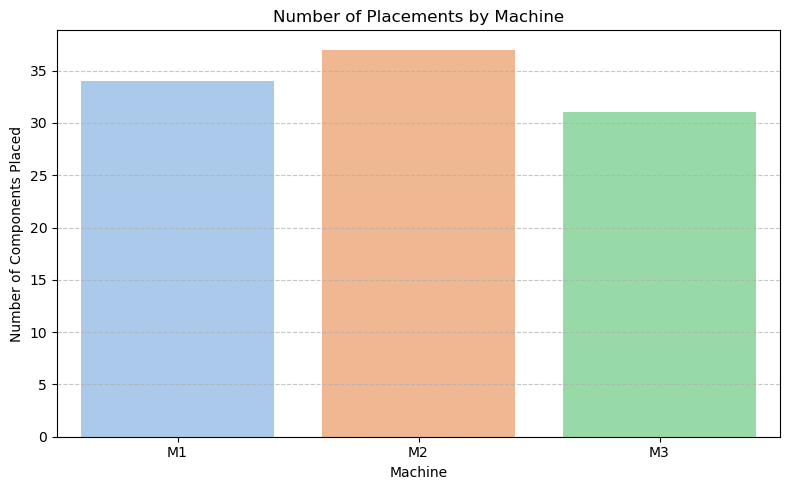

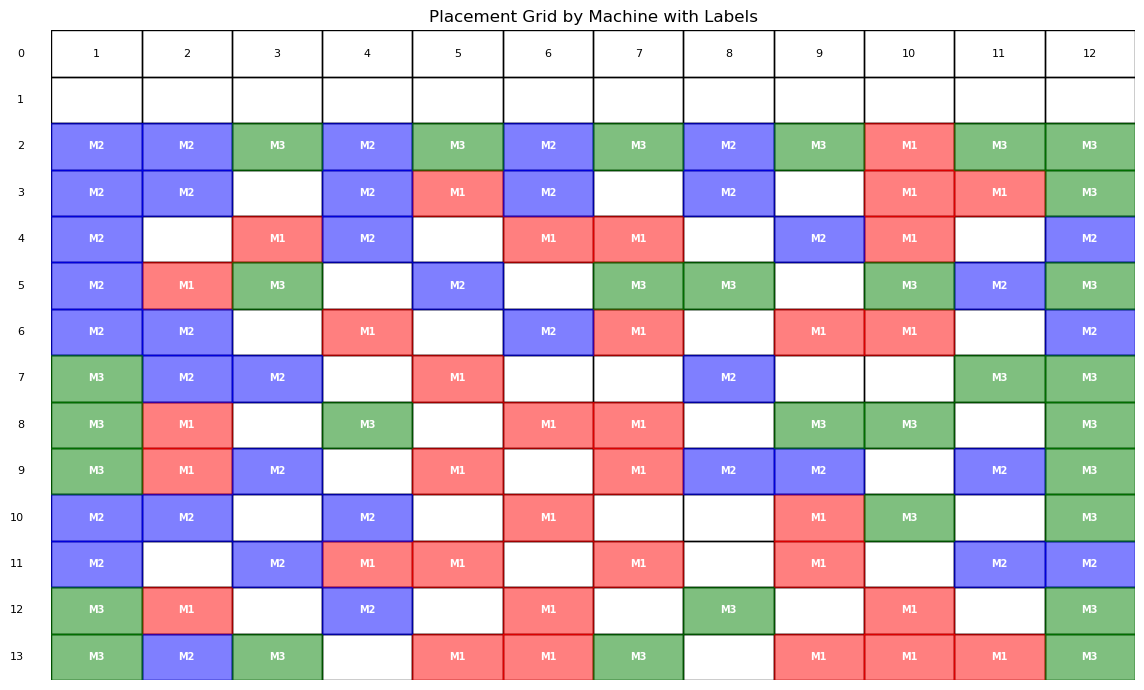

In [ ]:
def dist_test(p1, p2):
    return math.hypot(p1[0] - p2[0], p1[1] - p2[1])

print(dist_test((2, 12), (3, 0)))
# 测试函数 

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 读取数据文件
file_path = 'optimized_board_assembly_batch3_HOME.csv'  # ← 改为你的CSV路径
df = pd.read_csv(file_path)

# 定义颜色映射：为不同机器分配颜色
machine_colors = {
    'M1': 'red',
    'M2': 'blue',
    'M3': 'green',
    'M4': 'orange',
    'M5': 'purple',
}

# 筛选安装步骤（"Plc"表示贴装）
plc_df = df[df['Step'].str.contains('Plc')].copy()

# 提取目标位置坐标并转为整数
plc_df[['To_x', 'To_y']] = plc_df['To'].str.strip('()').str.split(',', expand=True).astype(int)

import seaborn as sns

# 统计每台机器安装的零件数量（仅Plc步骤）
machine_counts = plc_df['Machine'].value_counts().sort_index()

# 绘制柱状图
plt.figure(figsize=(8, 5))
sns.barplot(x=machine_counts.index, y=machine_counts.values, palette='pastel')

plt.title("Number of Placements by Machine")
plt.xlabel("Machine")
plt.ylabel("Number of Components Placed")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


# 创建图形窗口
fig, ax = plt.subplots(figsize=(11.5, 7))
ax.set_xlim(1, 13)  # 忽略最左边一列
ax.set_ylim(0, 14)
ax.invert_yaxis()   # 让第0行在上面

# 绘制网格
for x in range(1, 13):
    for y in range(14):
        ax.add_patch(patches.Rectangle((x, y), 1, 1, fill=False, edgecolor='black'))

# 添加列与行编号（列编号改为 1–12）
for x in range(1, 13):
    ax.text(x + 0.5, 0.5, str(x), va='center', ha='center', fontsize=8)
for y in range(14):
    ax.text(0.7, y + 0.5, str(y), va='center', ha='right', fontsize=8)

# 为每个贴装位置上色并添加标签
for _, row in plc_df.iterrows():
    x, y = row['To_x'], row['To_y']
    if x >= 1:  # 忽略最左一列
        machine = row['Machine']
        color = machine_colors.get(machine, 'gray')
        ax.add_patch(patches.Rectangle((x, y), 1, 1, color=color, alpha=0.5))
        ax.text(x + 0.5, y + 0.5, machine, ha='center', va='center',
                fontsize=7, color='white', weight='bold')


# 图标题与样式
plt.title("Placement Grid by Machine with Labels")
plt.axis('off')
plt.tight_layout()
plt.show()
